<a href="https://colab.research.google.com/github/dbetm/DeepLearningLifeSciences/blob/main/Chapter08/Diagnose_Diabetic_Retinopathy_Progression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem:** Diagnose diabetic retinopahty patient progression (classification over images of patient's fundus).

Diabetic retinopathy is a condition in which diabetes damages the health of the eyes. It is a major cause of blindness.

**Dataset:** [APTOS 2019 Blindness Detection](https://www.kaggle.com/c/aptos2019-blindness-detection/data)

High-resolution retina images taken under a variety of imaging conditions.

A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4, according to the following scale:

* 0 - No DR
* 1 - Mild
* 2 - Moderate
* 3 - Severe
* 4 - Proliferative DR

**Dataset split:**
- train images: 3662 images (65.5%)
- test images: 1928 images (34.5%)

9.52 GB


**Important:** The book suggests another dataset -> [Kaggle competition - Diabetic Retinopathy Detection](https://www.kaggle.com/c/diabetic-retinopathy-detection/overview) but the data is very large to host on Colab.

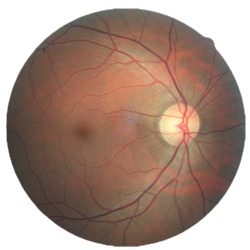

## Setup

**Important**: Activate GPU (runtime type).

### Kaggle

You need to setup API CLI of Kaggle in order to get the dataset.

Please follow the steps below to download and use kaggle data within Google Colab:

1.   You need to create an account on [Kaggle](https://www.kaggle.com/) (if you don't have one yet).
2.  Go to your profile > *Account* (tab) > *API* (section): *Create New API Token*, this will download a .json file (`kaggle.json`) on your computer or device with your API KEY (please don't share with any one).



In [1]:
# Install CLI Kaggle
!pip install -U -q kaggle==1.5.8

In [ ]:
from google.colab import files
# Load your API KEY file
files.upload() # please select your kaggle.json

# Important: Please, clear the output, after completation.

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### DeepChem

In [4]:
!pip install --pre deepchem
import deepchem as dc
dc.__version__

'2.6.0.dev'

## Dataset

In [ ]:
# Download data from Kaggle (~3 minutes, Google internet speed)
!mkdir dataset
!kaggle competitions download aptos2019-blindness-detection -p dataset

In [ ]:
# Uncompress the dataset
!unzip "dataset/aptos2019-blindness-detection.zip" -d "dataset"

In [7]:
# Remove .zip file (dataset)
!rm dataset/aptos2019-blindness-detection.zip

In [8]:
# Reading csv files for test and train dataset.
# They are both contain names of the images (id_code).

import pandas as pd

test_data = pd.read_csv(r'dataset/test.csv')
train_data = pd.read_csv(r'dataset/train.csv')

print(train_data)

           id_code  diagnosis
0     000c1434d8d7          2
1     001639a390f0          4
2     0024cdab0c1e          1
3     002c21358ce6          0
4     005b95c28852          0
...            ...        ...
3657  ffa47f6a7bf4          2
3658  ffc04fed30e6          0
3659  ffcf7b45f213          2
3660  ffd97f8cd5aa          0
3661  ffec9a18a3ce          2

[3662 rows x 2 columns]


### Resizing images
fx - width, fy - height) 

In [9]:
import cv2

In [10]:
def resize_image(image_path, img_size=(256, 256)):
  image = cv2.imread(image_path)

  image = cv2.resize(image, (int(img_size[0]), int(img_size[1])))

  cv2.imwrite(image_path, image)


### Creating DeepChem dataset

In [11]:
import os

import numpy as np

data_dir = os.path.join('dataset', 'train_images')

In [12]:
images_full_paths = ['{}/{}.png'.format(data_dir, id) for id in train_data['id_code']]
data_mapping = dict(zip(*np.transpose(np.array(train_data))))
labels = np.array(train_data['diagnosis']).reshape((-1, 1))

In [ ]:
print(images_full_paths[:20])
print(labels[:20])

In [14]:
# resize all images
from tqdm.notebook import tqdm


for image_path in tqdm(images_full_paths):
  resize_image(image_path, img_size=(335, 256))

In [15]:
# classes and num of instances per class
classes, counts = np.unique(list(data_mapping.values()), return_counts=True)
print(classes, counts) # unbalanced data per class, so we need to define weights

[0 1 2 3 4] [1805  370  999  193  295]


In [16]:
# We seek to make it up the classes with less data giving a larger weight
weight_ratio = dict(zip(classes, np.max(counts) / counts.astype(float)))
print('Weight ratios: {}'.format(weight_ratio))

# Define weight for each label in labels array
weights = np.array([weight_ratio[label[0]] for label in labels]).reshape((-1, 1))
print(weights[:3])

Weight ratios: {0: 1.0, 1: 4.878378378378378, 2: 1.8068068068068068, 3: 9.352331606217616, 4: 6.11864406779661}
[[1.80680681]
 [6.11864407]
 [4.87837838]]


In [18]:
# Create DeepChem dataset
dataset = dc.data.ImageDataset(X=images_full_paths, y=labels, w=weights)
# Split
splitter = dc.splits.RandomSplitter()
train_set, valid_set, test_set = splitter.train_valid_test_split(
  dataset=dataset,
  frac_train=0.80,
  frac_valid=0.1,
  frac_test=0.1
)

In [19]:
print("Train dataset - num instances: ", len(train_set))
print("Valid dataset - num instances: ", len(valid_set))

Train dataset - num instances:  2929
Valid dataset - num instances:  366


## Model
We are going to use defined model (convolutional neural network) by [book's repository](https://github.com/deepchem/DeepLearningLifeSciences). 

In [20]:
import requests

url = 'https://raw.githubusercontent.com/dbetm/DeepLearningLifeSciences/main/08_Medicine/model.py'
answer = requests.get(url)

with open('model.py', 'w') as f:
  f.write(answer.text)

In [21]:
from model import DRModel, DRAccuracy, ConfusionMatrix, QuadWeightedKappa

In [22]:
# Create model
image_dims = (256, 335, 3)

model = DRModel(
  n_tasks=1,
  image_dims=image_dims,
  n_init_kernel=32,
  n_classes=len(classes),
  augment=False,
  batch_size=64,
  learning_rate=1e-4
)

In [23]:
# Metrics,
metrics = [
  # accuracy - percent of labels which are correct
  dc.metrics.Metric(DRAccuracy, mode='classification', classification_handling_mode='direct'),
  # this coefficient is used to measure inter-rater reliability for qualitative items.
  # https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps
  dc.metrics.Metric(QuadWeightedKappa, mode='classification', classification_handling_mode='direct')
]

In [30]:
from tqdm.notebook import trange

# fit (~10 minutes)
num_classes = len(classes)
num_epochs = 30

for x in trange(num_epochs // 10):
  model.fit(train_set, nb_epoch=10)
  print('About to start train metrics evaluation')
  print(model.evaluate(train_set, metrics, n_classes=num_classes))

  print('About to start valid metrics evaluation')
  print(model.evaluate(valid_set, metrics, n_classes=num_classes))


About to start train metrics evaluation
{'DRAccuracy': 0.9300102424035507, 'QuadWeightedKappa': 0.9379595719817064}
About to start valid metrics evaluation
{'DRAccuracy': 0.7103825136612022, 'QuadWeightedKappa': 0.7148919697773445}
About to start train metrics evaluation
{'DRAccuracy': 0.9887333560942301, 'QuadWeightedKappa': 0.9906565329616677}
About to start valid metrics evaluation
{'DRAccuracy': 0.680327868852459, 'QuadWeightedKappa': 0.73247537565605}
About to start train metrics evaluation
{'DRAccuracy': 0.9931717309662, 'QuadWeightedKappa': 0.995966612252424}
About to start valid metrics evaluation
{'DRAccuracy': 0.7240437158469946, 'QuadWeightedKappa': 0.6868220451735094}



## Performance
Evaluate with test and validation dataset.

### Evaluation

In [31]:
print('About to start train metrics evaluation')
print(model.evaluate(train_set, metrics, n_classes=num_classes))

print('About to start valid metrics evaluation')
print(model.evaluate(valid_set, metrics, n_classes=num_classes))

print('About to start test metrics evaluation')
print(model.evaluate(test_set, metrics, n_classes=num_classes))

About to start train metrics evaluation
{'DRAccuracy': 0.9931717309662, 'QuadWeightedKappa': 0.995966612252424}
About to start valid metrics evaluation
{'DRAccuracy': 0.7240437158469946, 'QuadWeightedKappa': 0.6868220451735094}
About to start test metrics evaluation
{'DRAccuracy': 0.7057220708446866, 'QuadWeightedKappa': 0.6150543811372722}


**Note:** In order to get a better result, you can train with more epochs and make tunning.